# Images from the paper

This notebook intends to generate the images from the paper "On a bivariate beta distribution" from Lucas Moschen and Luiz Carvalho. 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import json
import sys
import numpy as np
from scipy.stats import kurtosis
from tqdm import tqdm, trange
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts/python')
from parameter_estimation import BivariateBeta
from experiments import starting_experiment, starting_experiment_2

#plt.style.use('ggplot')
plt.style.use('science')

## Plotting the bivariate pdf

This image plots the pdf for different values of $\alpha$.

In [4]:
def plotting_bivariate_beta_pdf(alphas, n_points = 100):
    """
    Plots a grid of 3 x 4 densities of the bivariate beta distribution 
    with parameter alpha.
    
    Parameters:
    | alphas (12 x 4 - array): each line represents a different parameter specification.
    | n_points (int): numper of points to devide each component of the grid.
    """
    x_values = y_values = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x_values, y_values)
    Z = np.zeros_like(X)

    fig = plt.figure(figsize = (14, 9))

    for k, alpha in tqdm(enumerate(alphas)):
        distribution = BivariateBeta(alpha=alpha)
        for i,x in enumerate(x_values): 
            for j,y in enumerate(y_values): 
                Z[i,j] = distribution.pdf(x, y)
    
        ax = fig.add_subplot(3, 4, k+1, projection='3d') 
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       cmap=sns.color_palette("magma", as_cmap=True), edgecolor='none')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(r"$\alpha =$ {}".format(alpha))
    fig.tight_layout()
    plt.savefig('../figures/joint-densities-bivariate-beta.pdf', bbox_inches = 'tight')

12it [00:42,  3.56s/it]


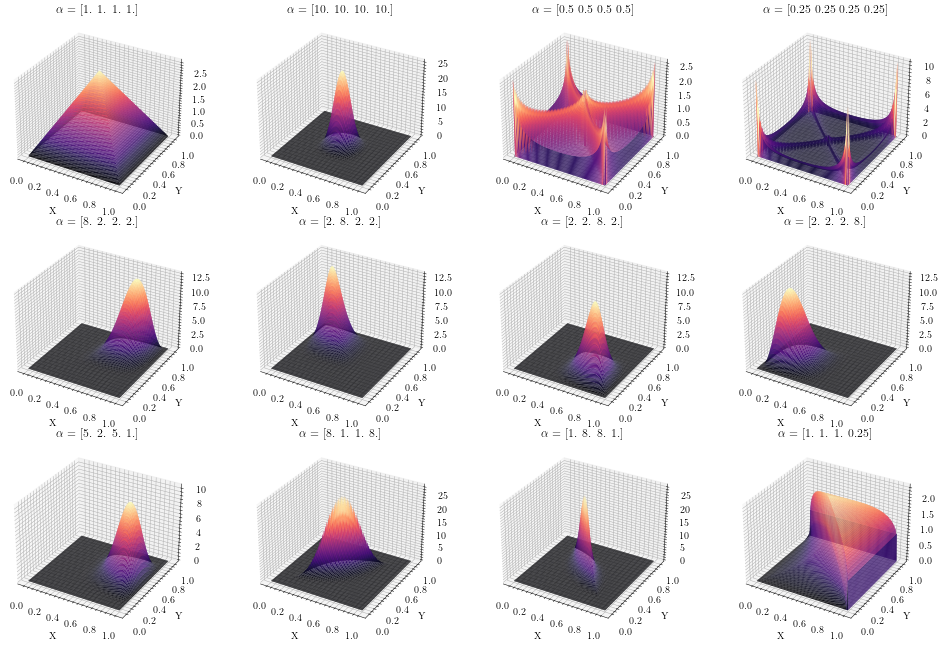

In [5]:
alphas = np.array([[1,1,1,1],
                [10,10,10,10],
                [.5,.5,.5,.5],
                [.25,.25,.25,.25],
                [8,2,2,2],
                [2,8,2,2],
                [2,2,8,2],
                [2,2,2,8],
                [5,2,5,1],
                [8,1,1,8],
                [1,8,8,1],
                [1,1,1,0.25],
                ])

plotting_bivariate_beta_pdf(alphas)
plt.show()

## Representation of the moment sets where there is no bivariate beta

In [90]:
def plotting_positive_sets(v1_list, rho_list, n_points = 1000): 
    """
    Plots the sets where the solution to the system is strictly positive.
    Parameters:
    | v1_list (list): list of values for v1
    | rho_list (list): list of values for rho
    """ 
    distribution = BivariateBeta()
    def z_function(m1, m2, v1, rho):
        return 1*(sum(distribution._system_solution(m1, m2, v1, rho) <= 0) == 0) - 1*(v1 >= m1 - m1*m1)
    m1 = np.linspace(0, 1, n_points, endpoint=False)
    m2 = np.linspace(0, 1, n_points, endpoint=False)

    fig, ax = plt.subplots(3,5,figsize = (16,7), sharex = True, sharey = True)
    colors = ['grey', '#ef8a62', '#67a9cf']
    for k, (v1, rho) in enumerate(zip(v1_list, rho_list)): 
        i = k // 5
        j = k % 5
        x, y = np.meshgrid(m1,m2)
        data = z_function(x, y, v1, rho)
        ax[i,j].contourf(x, y, data, levels = [-1, -0.1, 0.5, 1], colors = colors )
        ax[i,j].set_title(r'$v_1$ = {} and $\rho$ = {}'.format(v1, rho), fontsize = 12)
        
    for i in range(3): 
        ax[2,i].set_xlabel(r'$m_1$', fontsize = 15)
        ax[i,0].set_ylabel(r'$m_2$', fontsize = 15)
    ax[2,3].set_xlabel(r'$m_1$', fontsize = 15)
    ax[2,4].set_xlabel(r'$m_1$', fontsize = 15)
        
    fig.legend(handles = [mpatches.Patch(color=colors[0], label=r'$v_1 > m_1 - m_1^2$'.format(k+1)),
                          mpatches.Patch(color=colors[1], label=r'$\alpha_i < 0$ for some $i$'.format(k+1)),
                          mpatches.Patch(color=colors[2], label=r'$\alpha_1, \dots, \alpha_4 > 0$'.format(k+1))], 
               loc = 'lower right', fontsize=12)
    plt.savefig('../figures/alpha_solution_existence.pdf', bbox_inches = 'tight')

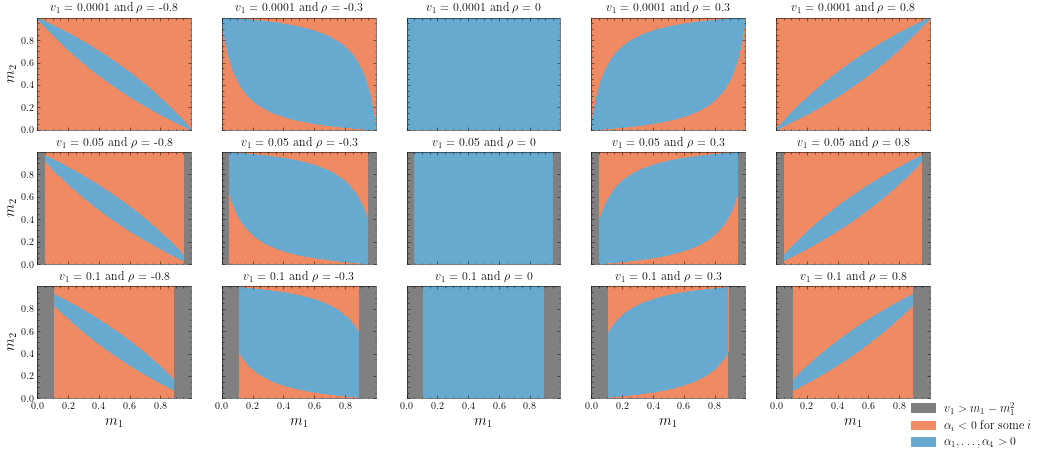

In [91]:
plotting_positive_sets([0.0001]*5 + [0.05]*5 + [0.1]*5, 
                       [-0.8, -0.3, 0, 0.3, 0.8]*4)
plt.show()

## Proposition 5 interval

Here we see the interval length for $\rho$ to define a bivariate beta for different values of $m_1$ and $m_2$.

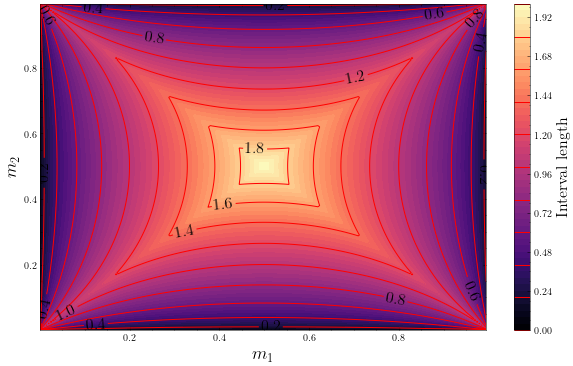

In [8]:
interval = np.linspace(1e-8, 1, endpoint=False, num=200)
m1, m2 = np.meshgrid(interval, interval)
length = lambda m1, m2: ((np.minimum(m1, m2)-m1*m2) + np.minimum(m1*m2, (1-m1)*(1-m2)))/np.sqrt(m1*m2*(1-m1)*(1-m2))
z = length(m1, m2)

fig, ax = plt.subplots(figsize=(10,6))
c = ax.contourf(m1, m2, z, cmap='magma', levels=50)
c2 = ax.contour(c, levels=c.levels[::5], colors='red', origin='lower')
ax.clabel(c2, fmt='%2.1f', colors='k', fontsize=16)

cbar = fig.colorbar(c)
cbar.add_lines(c2)
cbar.set_label('Interval length', fontsize=16)

ax.set_xlabel(r'$m_1$', fontsize=18)
ax.set_ylabel(r'$m_2$', fontsize=18)

plt.savefig('../figures/rho_interval_length_different_means.pdf', bbox_inches = 'tight')

## Comparing the methods

Here we compare the methods (MAPE and bias)

In [40]:
def comparing_methods(true_alpha, monte_carlo_size, bootstrap_size, seed, name):

    filename1 = starting_experiment(true_alpha, 50, monte_carlo_size, bootstrap_size, seed)
    filename2 = starting_experiment(true_alpha, 200, monte_carlo_size, bootstrap_size, seed)
    with open(filename1, 'r') as f:
        experiment1 = json.load(f)
    with open(filename2, 'r') as f:
        experiment2 = json.load(f)

    methods = ['MM1', 'MM2', 'MM3', 'MM4']

    bias1 = [np.mean(np.abs(experiment1['bias'][i])) for i in range(4)]
    mape1 = [np.mean(experiment1['mape'][i]) for i in range(4)]
    bias2 = [np.mean(np.abs(experiment2['bias'][i])) for i in range(4)]
    mape2 = [np.mean(experiment2['mape'][i]) for i in range(4)]

    fig, ax = plt.subplots(2,2, figsize=(10,6))

    ax[0,0].bar(methods, mape1, color='grey', edgecolor = "black")
    ax[0,1].bar(methods, bias1, color='grey', edgecolor = "black")
    ax[1,0].bar(methods, mape2, color='grey', edgecolor = "black")
    ax[1,1].bar(methods, bias2, color='grey', edgecolor = "black")

    size=20
    ax[0,0].set_ylabel(r'$n=50$', fontsize=size)
    ax[1,0].set_ylabel(r'$n=200$', fontsize=size)
    ax[0,0].set_title('Average MAPE', fontsize=size)
    ax[0,1].set_title('Average absolute bias', fontsize=size)

    ax[0,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[1,0].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[0,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax[1,1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

    fig.tight_layout() 
    plt.savefig(os.path.join('..', 'figures', 'comparing_methods_mape_bias_{}.pdf'.format(name)), bbox_inches='tight')
    plt.show()

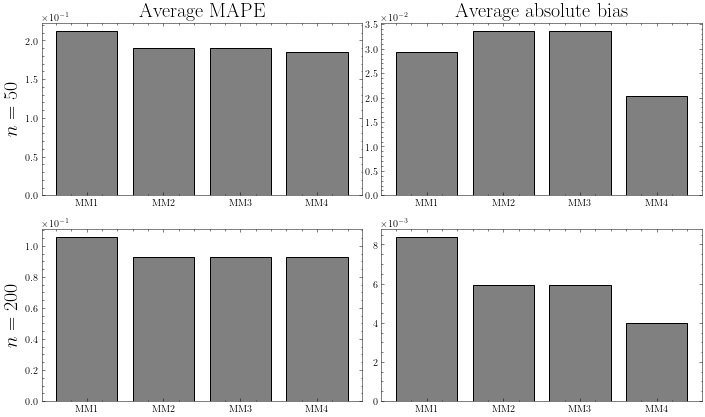

In [14]:
comparing_methods(true_alpha=np.array([1, 1, 1, 1]),
                  monte_carlo_size=1000, 
                  bootstrap_size=500, 
                  seed=7892739,
                  name='001')

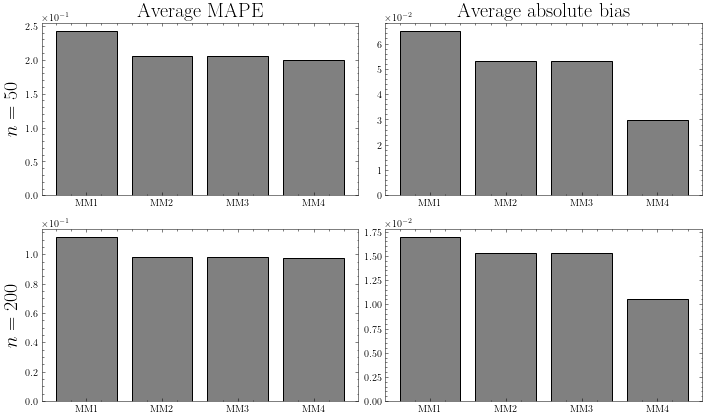

In [41]:
comparing_methods(true_alpha=np.array([0.7, 0.9, 2.0, 1.5]),
                  monte_carlo_size=1000, 
                  bootstrap_size=500, 
                  seed=7892739,
                  name='002')

### Comparing time of execution

In [13]:
def comparing_exec_times(true_alpha, monte_carlo_size, bootstrap_size, seed):

    filename = starting_experiment(true_alpha, 50, monte_carlo_size, bootstrap_size, seed)
    with open(filename, 'r') as f:
        experiment = json.load(f)
        
    print(experiment['comp'][:4])

    methods = ['MM1', 'MM2', 'MM3', 'MM4']
    plt.figure(figsize=(6,4))
    plt.bar(methods, experiment['comp'][:4], color='grey', edgecolor='black')
    plt.ylabel('Time (s)', fontsize=20)
    plt.title('Comparing estimation runtime', fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.savefig(os.path.join('..', 'figures', 'runtime_moments_methods.pdf'), bbox_inches='tight')
    plt.show()

[0.0004706883430480957, 0.00027366280555725093, 0.0027652790546417237, 0.02695711064338684]


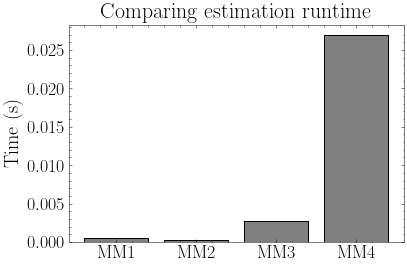

In [14]:
comparing_exec_times(true_alpha=np.array([2, 7, 3, 1]),
                  monte_carlo_size=1000, 
                  bootstrap_size=500, 
                  seed=7892739)

In [60]:
def comparing_methods2(mu1, mu2, sigma1, sigma2, sample_size, monte_carlo_size, seed):

    filename1 = starting_experiment_2(mu1, sigma1, sample_size, monte_carlo_size, seed)
    filename2 = starting_experiment_2(mu2, sigma2, sample_size, monte_carlo_size, seed)
    with open(filename1, 'r') as f:
        experiment1 = json.load(f)
    with open(filename2, 'r') as f:
        experiment2 = json.load(f)

    values = [r'$\mathbb{E}[X]$', r'$\mathbb{E}[Y]$', r'$\operatorname{var}(X)$', r'$\operatorname{var}(Y)$', r'$\operatorname{cor}(X,Y)$']
    mape1_mm1 = experiment1['mape'][0]
    mape2_mm1 = experiment2['mape'][0]
    mape1_mm4 = experiment1['mape'][3]
    mape2_mm4 = experiment2['mape'][3]

    fig, ax = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

    color = 'grey'
    edgecolor = 'black'
    ax[0,0].bar(values, mape1_mm1, color=color, edgecolor=edgecolor)
    ax[0,1].bar(values, mape2_mm1, color=color, edgecolor=edgecolor)
    ax[1,0].bar(values, mape1_mm4, color=color, edgecolor=edgecolor)
    ax[1,1].bar(values, mape2_mm4, color=color, edgecolor=edgecolor)

    ax[0,0].set_ylabel('MAPE MM1', fontsize=18)
    ax[1,0].set_ylabel('MAPE MM4', fontsize=18)
    ax[0,0].set_title('Experiment 1', fontsize=20)
    ax[0,1].set_title('Experiment 2', fontsize=20)
    
    ax[1,0].tick_params(axis='both', which='major', labelsize=14)
    ax[1,1].tick_params(axis='both', which='major', labelsize=14)
    ax[0,0].tick_params(axis='both', which='major', labelsize=14)

    fig.tight_layout() 
    plt.savefig(os.path.join('..', 'figures', 'logit_normal_mape_experiments.pdf'), bbox_inches='tight')
    plt.show()

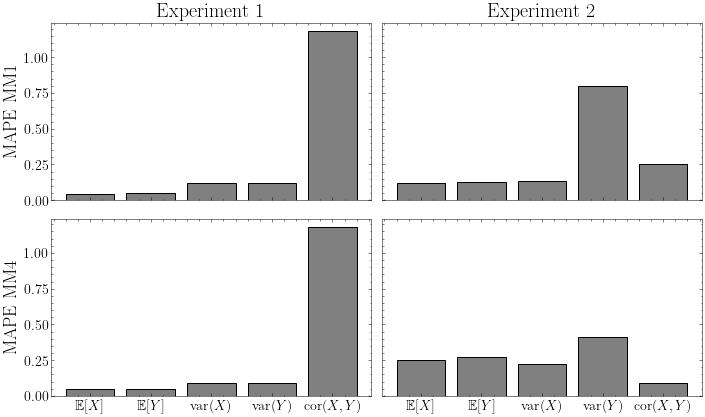

In [61]:
comparing_methods2(mu1=np.array([0,0]), 
                   mu2=np.array([-1.0, -1.0]), 
                   sigma1=np.array([[1, 0.1], [0.1, 1]]), 
                   sigma2=np.array([[2.25, -1.2], [-1.2, 1.0]]), 
                   sample_size=50, 
                   monte_carlo_size=1000, 
                   seed=7892739)

In [85]:
def comparing_methods3(mu, sigma, sample_size, monte_carlo_size, seed):

    filename = starting_experiment_2(mu, sigma, sample_size, monte_carlo_size, seed)
    with open(filename, 'r') as f:
        experiment = json.load(f)

    ind = 2*np.arange(6) 
    width = 0.35

    _, ax = plt.subplots(figsize=(9,4))

    colors = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']
    for i in range(4):
        ax.bar(ind + i*width, 
               np.hstack([experiment['bias'][i], np.mean(experiment['bias'][i])]), 
               width=width,
               color=colors[i],
               edgecolor='black',
               label='MM{}'.format(i+1)
               )
    ax.set_xticks(ind + width)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticklabels((r'$\mathbb{E}[X]$', r'$\mathbb{E}[Y]$', r'$\operatorname{var}(X)$', r'$\operatorname{var}(Y)$', 
                        r'$\operatorname{cor}(X,Y)$', 'Average'))
    ax.set_title('Bias estimate for the methods of moments', fontsize=20)
    ax.legend(fontsize=16, loc='upper left')
    plt.savefig(os.path.join('..', 'figures', 'bias_estimate_moments_logit_normal.pdf'), bbox_inches='tight')
    plt.show()

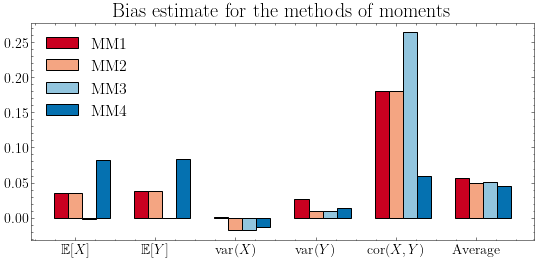

In [86]:
comparing_methods3(mu=np.array([-1.0, -1.0]), 
                   sigma=np.array([[2.25, -1.2], [-1.2, 1.0]]), 
                   sample_size=50, 
                   monte_carlo_size=1000, 
                   seed=7892739)

In [34]:
def parameter_variation(true_alpha, sample_size, monte_carlo_size, seed, alpha_i):
    """
    It does the experiments from Section "Recovering parameters from bivariate beta".
    """
    rng = np.random.default_rng(seed)
    distribution = BivariateBeta()

    moments_vs_alpha = np.zeros((monte_carlo_size, 6))

    for k in range(monte_carlo_size):
        U = rng.dirichlet(true_alpha, size=sample_size)
        X = U[:, 0] + U[:, 1]
        Y = U[:, 0] + U[:, 2]

        alpha_hat1 = distribution.method_moments_estimator_1(X, Y)

        moments_vs_alpha[k, 0] = X.mean()
        moments_vs_alpha[k, 1] = Y.mean()
        moments_vs_alpha[k, 2] = X.var(ddof=1)
        moments_vs_alpha[k, 3] = Y.var(ddof=1)
        moments_vs_alpha[k, 4] = np.corrcoef(X,Y)[0,1]
        moments_vs_alpha[k, 5] = alpha_hat1[alpha_i-1]

    names = [r'$\hat{m}_1$', r'$\hat{m}_2$', r'$\hat{v}_1$', r'$\hat{v}_2$', r'$\hat{\rho}$']

    fig, ax = plt.subplots(1, 5, figsize=(20,4), sharey=True)
    fig.suptitle('Sensitivity analysis', fontsize=24)
    for i in range(5):
        ax[i].scatter(moments_vs_alpha[:,i], moments_vs_alpha[:,-1], s=3, color='grey', edgecolor='black')
        ax[i].set_xlabel(names[i], fontsize=20)
    ax[0].set_ylabel(r'$\hat\alpha_{}$'.format(alpha_i), fontsize=20)

    plt.savefig(os.path.join('..', 'figures', 'sensibility_analysis_alpha{}.pdf'.format(alpha_i)), 
                bbox_inches='tight')
    plt.show()  

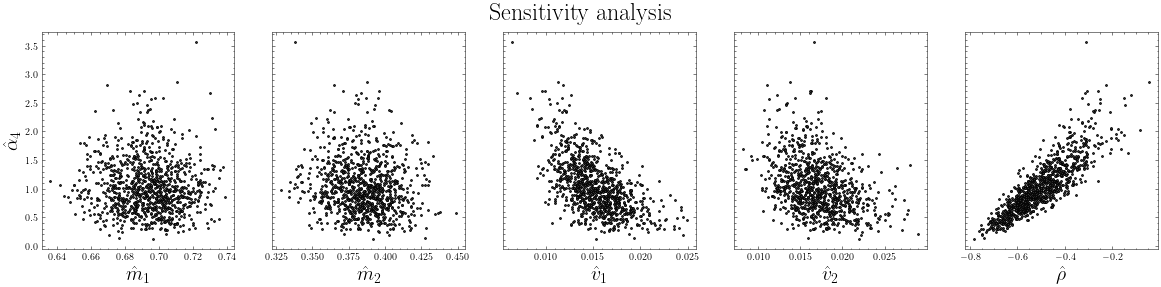

In [35]:
parameter_variation(true_alpha=np.array([2, 7, 3, 1]),
                    monte_carlo_size=1000, 
                    sample_size=50, 
                    seed=7892739,
                    alpha_i=4)

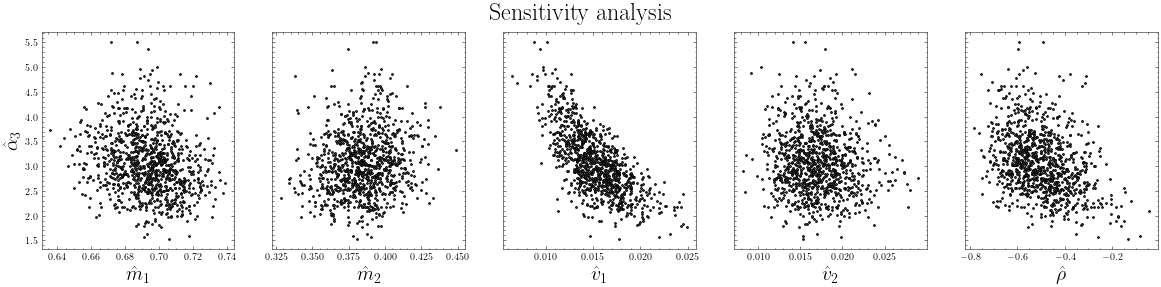

In [36]:
parameter_variation(true_alpha=np.array([2, 7, 3, 1]),
                    monte_carlo_size=1000, 
                    sample_size=50, 
                    seed=7892739,
                    alpha_i=3)

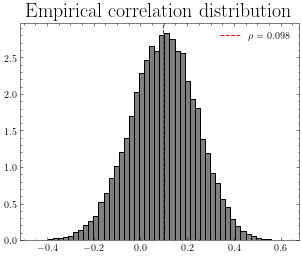

In [87]:
rho_hat_samples = np.zeros(20000)    
for i in range(20000):
    Z = np.random.multivariate_normal(mean=[0,0], cov=[[1, 0.1], [0.1, 1]], size=50)
    X = 1/(1 + np.exp(-Z[:,0]))
    Y = 1/(1 + np.exp(-Z[:,1]))
    rho_hat_samples[i] = np.corrcoef(X, Y)[0,1]

Z_true = np.random.multivariate_normal(mean=[0,0], cov=[[1, 0.1], [0.1, 1]], size=1000000)
true_value = np.corrcoef(1/(1 + np.exp(-Z_true[:,0])), 1/(1 + np.exp(-Z_true[:,1])))[0,1]

plt.figure(figsize=(5,4))
plt.title('Empirical correlation distribution', fontsize=20)
plt.hist(rho_hat_samples, color='grey', edgecolor='black', bins=50, density=True)
plt.axvline(true_value, color='red', linestyle='--', label=r'$\rho$ = {:.3f}'.format(true_value))
plt.legend()
plt.savefig('../figures/sample_distribution_rho.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def bootstrap_plot():
    
    true_alpha = np.array([2,4,3,1])
    ro = np.random.default_rng(np.random.randint(31829))
    distribution = BivariateBeta()
    sample_sizes = [10, 20, 50, 100, 200, 1000]
    bootstrap_samples = list(range(50, 5000, 50))
    ci_alpha1 = np.zeros((2, len(bootstrap_samples)))

    fig, ax = plt.subplots(2, 3)

    for ind, sample_size in tqdm(enumerate(sample_sizes)):
        i = ind // 3
        j = ind % 3
        U = ro.dirichlet(true_alpha, size=sample_size)
        X = U[:, 0] + U[:, 1]
        Y = U[:, 0] + U[:, 2]
        for b in bootstrap_samples:
            samples = distribution.bootstrap_method(X, Y, B=b, method=distribution.method_moments_estimator_1, processes=4)
            ci_alpha1[:, (b-50)//50] = distribution.confidence_interval(level=0.95, samples=samples)[:, 0]
        ax[i,j].plot(bootstrap_samples, ci_alpha1[0])
        ax[i,j].plot(bootstrap_samples, ci_alpha1[1])
        ax[i,j].set_title('n={}'.format(sample_size))
    plt.show()

## Are the density close?

In [11]:
mu1 = np.array([0,0])
mu2 = np.array([-1,-1])
sigma1 = np.array([[1, 0.1], [0.1, 1]])
sigma2 = np.array([[2.25, -1.2], [-1.2, 1]])
n = 50

rng = np.random.default_rng(seed=82332)

samples = 1000000
G = [rng.multivariate_normal(mean=mu1, cov=sigma1, size=samples),
     rng.multivariate_normal(mean=mu2, cov=sigma2, size=samples)]

X, Y = [1/(1+np.exp(-G[i][:,0])) for i in [0,1]], [1/(1+np.exp(-G[i][:,1])) for i in [0,1]]

n_values = [50, 200, 1000]

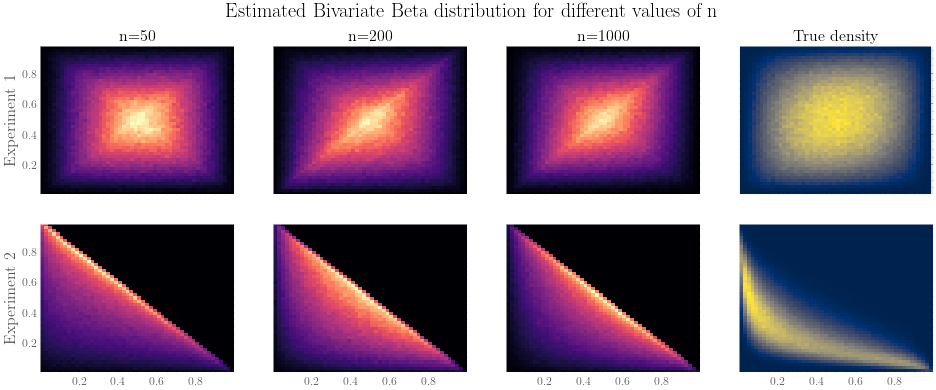

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(16,6), sharex=True, sharey=True)

for i in range(2):
    for j in range(len(n_values)+1):
        ax[0,j].set_title(['n=50', 'n=200', 'n=1000', 'True density'][j], fontsize=16)
        ax[i,j].tick_params(axis='both', which='major', labelsize=12)
        ax[i,j].set_axisbelow(True)
    ax[i,0].set_ylabel(['Experiment 1', 'Experiment 2'][i], fontsize=16)

for i in range(2):
    for j, n in enumerate(n_values):

        alpha_hat = BivariateBeta().method_moments_estimator_4(X[i][:n], Y[i][:n], alpha0=(1,1,1,1))
        alpha_hat[alpha_hat <= 0] += 1e-16
        U = rng.dirichlet(alpha_hat, size=samples)
        X_hat = U[:,0] + U[:,1]
        Y_hat = U[:,0] + U[:,2]

        ax[i,j].hist2d(X_hat, Y_hat, bins=[50,50], density=True, cmap=plt.cm.magma, rasterized=True)
    ax[i,-1].hist2d(X[i], Y[i], bins=[50,50], density=True, cmap=plt.cm.cividis, rasterized=True)
    
fig.suptitle('Estimated Bivariate Beta distribution for different values of n', fontsize=20)
plt.savefig('../figures/estimated_distributions_against_true.pdf', dpi=300)
plt.show()

In [20]:
alpha_hat = BivariateBeta().method_moments_estimator_4(X[0], Y[0], alpha0=(1,1,1,1))
alpha_hat[alpha_hat <= 0] += 1e-16
U = rng.dirichlet(alpha_hat, size=samples)
X_hat = U[:,0] + U[:,1]
Y_hat = U[:,0] + U[:,2]
print(kurtosis(X[0]))
print(kurtosis(X_hat[0]))

-0.8588399090356549
-3.0


## Additional experiments

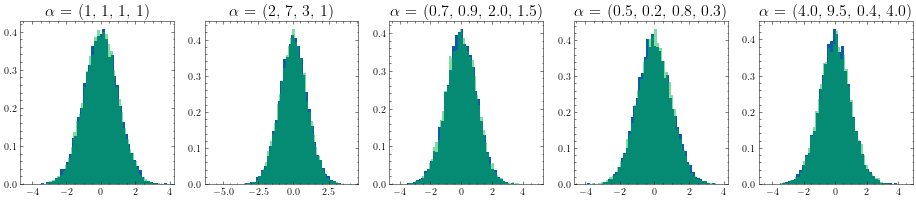

In [42]:
alpha_values = [np.array([1,1,1,1]),
                np.array([2,7,3,1]),
                np.array([0.7,0.9, 2.0,1.5]),
                np.array([0.5,0.2,0.8,0.3]),
                np.array([4.0, 9.5, 0.4, 4.0])]
n = 30

fig, ax = plt.subplots(1,5, figsize=(16,3))

for i, true_alpha in enumerate(alpha_values):

    U = np.random.dirichlet(true_alpha, size=(10000, n))
    X = U[:,:,0] + U[:,:,1]
    Y = U[:,:,0] + U[:,:,2]
    
    m1 = X.mean(axis=1) 
    v1 = X.var(ddof=1, axis=1)
    m2 = Y.mean(axis=1) 
    v2 = Y.var(ddof=1, axis=1)
    
    S = m1*(1-m1)*v2 - m2*(1-m2)*v1
    mu = S.mean()
    sigma = S.std(ddof=1)
    
    ax[i].hist((S-mu)/sigma, bins=50, density=True)
    ax[i].hist(np.random.normal(size=10000), bins=50, alpha=0.5, density=True)
    ax[i].set_title(r'$\alpha$ = {}'.format(tuple(true_alpha)), fontsize=16)
plt.savefig('../figures/distribution_statistic_n30.pdf', bbox_inches='tight')
plt.show()

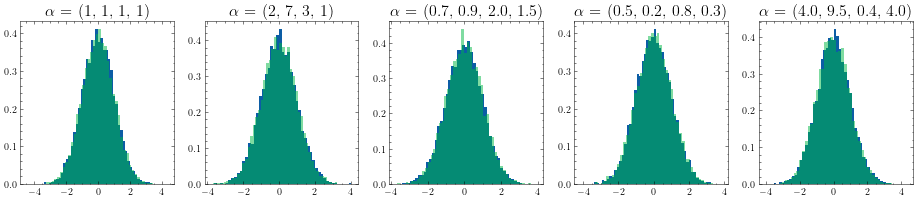

In [44]:
alpha_values = [np.array([1,1,1,1]),
                np.array([2,7,3,1]),
                np.array([0.7,0.9, 2.0,1.5]),
                np.array([0.5,0.2,0.8,0.3]),
                np.array([4.0, 9.5, 0.4, 4.0])]
n = 30

fig, ax = plt.subplots(1,5, figsize=(16,3))

for i, true_alpha in enumerate(alpha_values):

    U = np.random.dirichlet(true_alpha, size=n)
    X = np.random.beta(2, 2, size=n)#U[:,0] + U[:,1]
    Y = np.random.beta(1, 1, size=n)#U[:,0] + U[:,2]
    alpha_hat = BivariateBeta().method_moments_estimator_3(X,Y, alpha0=(1,1))
    
    U = np.random.dirichlet(alpha_hat, size=(10000, n))
    X = U[:,:,0] + U[:,:,1]
    Y = U[:,:,0] + U[:,:,2]
    m1 = X.mean(axis=1) 
    v1 = X.var(ddof=1, axis=1)
    m2 = Y.mean(axis=1) 
    v2 = Y.var(ddof=1, axis=1)
    
    S = m1*(1-m1)*v2 - m2*(1-m2)*v1
    mu = S.mean()
    sigma = S.std(ddof=1)
    
    ax[i].hist((S-mu)/sigma, bins=50, density=True)
    ax[i].hist(np.random.normal(size=10000), bins=50, alpha=0.5, density=True)
    ax[i].set_title(r'$\alpha$ = {}'.format(tuple(true_alpha)), fontsize=16)
#plt.savefig('../figures/distribution_statistic_n30.pdf', bbox_inches='tight')
plt.show()